In [1]:
!pip install swig
!pip install gymnasium
!pip install gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 40.6 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376102 sha256=a5e0b353648d6eaecabc12e23e9a03aa8b9936e87db2c713064bcefe4ab1b8f6
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6.0
    Uninstalling pygame-2.6.0:
      Successfully uninstalled pygame-2.6.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import gym
from gym import wrappers

import os
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
%matplotlib inline
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
from gym.wrappers import RecordEpisodeStatistics, RecordVideo

# batch DQN

In [ ]:
class DQN_Graph(nn.Module):
    """
    Deep Q-Learning Network Model Graph
    The neural network is a function from state space $R^{n_states}$ to action space $R^{n_actions}$
    """
    def __init__(self, n_states, n_actions, hidden_size=32):
        super(DQN_Graph, self).__init__()
        self.dense_layer_1 = nn.Linear(n_states, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, n_actions)

    def forward(self, state):
        x = F.relu(self.dense_layer_1(state))
        x = F.relu(self.dense_layer_2(x))
        return self.output_layer(x)

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [None] * capacity
        self.position = 0
        self.Transition = namedtuple('Transition',
                                     ('state', 'action', 'reward', 'next_state', 'done'))

    def size(self):
        return len(self.memory) - self.memory.count(None)

    def push(self, *args):
        self.memory[self.position] = self.Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def pull(self):
        return [exp for exp in self.memory if exp is not None]

    def sample(self, batch_size):
        exps = random.sample(self.pull(), batch_size)
        states = torch.tensor(np.vstack([e.state for e in exps if e is not None])).float().to(self.device)
        actions = torch.tensor(np.vstack([e.action for e in exps if e is not None])).long().to(self.device)
        rewards = torch.tensor(np.vstack([e.reward for e in exps if e is not None])).float().to(self.device)
        next_states = torch.tensor(np.vstack([e.next_state for e in exps if e is not None])).float().to(self.device)
        dones = torch.tensor(np.vstack([e.done for e in exps if e is not None]).astype(np.uint8)).float().to(self.device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)



class DQN_Agent():
    def __init__(self, n_states, n_actions, batch_size, hidden_size, memory_size,
                 update_step, learning_rate, gamma, tau):
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.update_step = update_step
        self.lr = learning_rate
        self.gamma = gamma
        self.tau = tau
        self.setup_gpu()
        self.setup_model()
        self.setup_opt()
        self.memory = ReplayMemory(memory_size)
        self.memory.device = self.device  # Ensure memory uses the correct device
        self.prepare_train()

    def setup_gpu(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def setup_model(self):
        self.policy_model = DQN_Graph(self.n_states, self.n_actions, self.hidden_size).to(self.device)
        self.target_model = DQN_Graph(self.n_states, self.n_actions, self.hidden_size).to(self.device)

    def setup_opt(self):
        self.opt = torch.optim.Adam(self.policy_model.parameters(), lr=self.lr)

    def prepare_train(self):
        self.steps = 0

    def act(self, state, epsilon):
        state = torch.tensor(state).reshape(1, -1).float().to(self.device)
        self.policy_model.eval()
        with torch.no_grad():
            action_vs = self.policy_model(state)
        self.policy_model.train()
        if np.random.random() > epsilon:
            return np.argmax(action_vs.cpu().detach().numpy())
        else:
            return np.random.randint(self.n_actions)

    def step(self, s, a, r, s_, done):
        self.memory.push(s, a, r, s_, done)
        self.steps = (self.steps + 1) % self.update_step
        if self.steps == 0 and self.memory.size() >= self.batch_size:
            exps = self.memory.sample(self.batch_size)
            self.learn(exps)

    def learn(self, exps):
        states, actions, rewards, next_states, dones = exps
        target_next_action_vs = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
        target_q_vs = rewards + (self.gamma * target_next_action_vs * (1 - dones))
        policy_q_vs = self.policy_model(states).gather(1, actions)
        loss = F.mse_loss(policy_q_vs, target_q_vs)
        self.opt.zero_grad()
        loss.backward()
        for p in self.policy_model.parameters():
            p.grad.data.clamp_(-1, 1)
        self.opt.step()
        for tp, lp in zip(self.target_model.parameters(), self.policy_model.parameters()):
            tp.data.copy_(self.tau*lp.data + (1.0-self.tau)*tp.data)

def dqn_learn_op(n_episodes, rewards_window_size, epsilon_array):
    best_avg_rewards = -30.
    total_rewards = []
    rewards_deque = deque(maxlen=rewards_window_size)
    t = trange(n_episodes)
    for episode in t:
        cur_state = env.reset()
        done = False
        rewards = 0
        epsilon = epsilon_array[episode]
        while not done:
            action = agent.act(cur_state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.step(cur_state, action, reward, next_state, done)
            cur_state = next_state
            rewards += reward
        total_rewards.append(rewards)
        rewards_deque.append(rewards)
        avg_rewards = np.mean(rewards_deque)
        t.set_description(
            'Episode {} Epsilon {:.2f} Reward {:.2f} Avg_Reward {:.2f} Best_Avg_Reward {:.2f}'.format(
                episode + 1, epsilon, rewards, avg_rewards, best_avg_rewards))
        t.refresh()
        if avg_rewards >= best_avg_rewards:
            best_avg_rewards = avg_rewards
            torch.save(agent.policy_model.state_dict(), DQN_CHECKPOINT_PATH)
        if best_avg_rewards > 200:
            break
    return total_rewards, rewards_deque


state space: 8
action space: 4


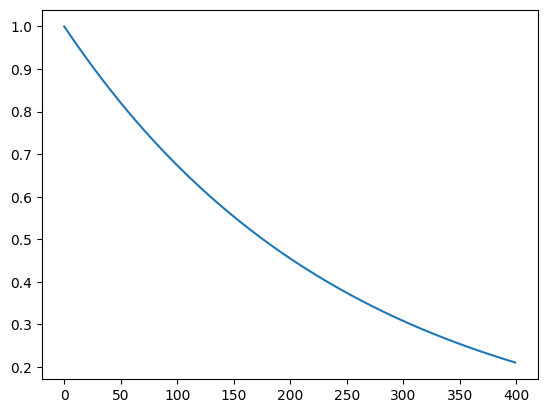

Episode 400 Epsilon 0.21 Reward 63.32 Avg_Reward 15.12 Best_Avg_Reward 13.95: 100%|██████████| 400/400 [12:38<00:00,  1.90s/it]


<Figure size 640x480 with 0 Axes>

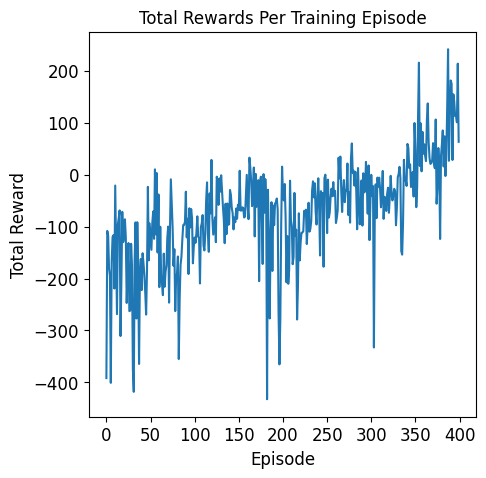

Episode 30.00 Reward 14.14: 100%|██████████| 30/30 [00:44<00:00,  1.47s/it]


<Figure size 640x480 with 0 Axes>

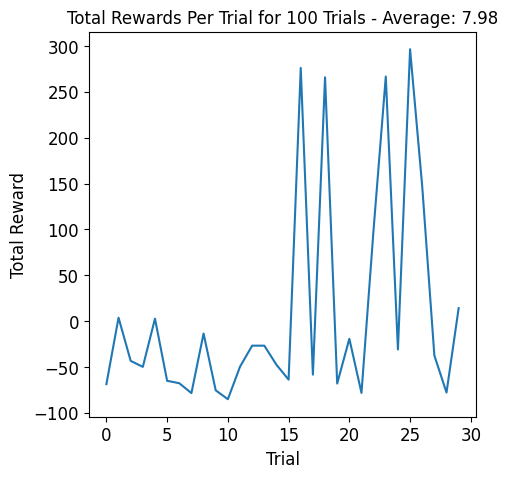

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/HW4/model with batch size_32/output/dqn_agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Total Rewards in this game: -68.62
state space: 8
action space: 4


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


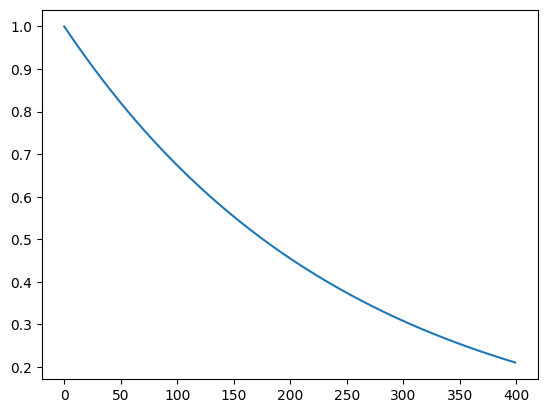

  0%|          | 0/400 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episode 400 Epsilon 0.21 Reward -125.46 Avg_Reward 58.17 Best_Avg_Reward 58.98: 100%|██████████| 400/400 [09:20<00:00,  1.40s/it]


<Figure size 640x480 with 0 Axes>

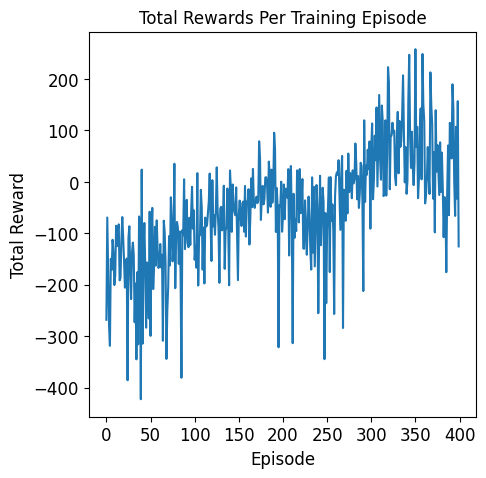

Episode 30.00 Reward -58.78: 100%|██████████| 30/30 [00:16<00:00,  1.84it/s]


<Figure size 640x480 with 0 Axes>

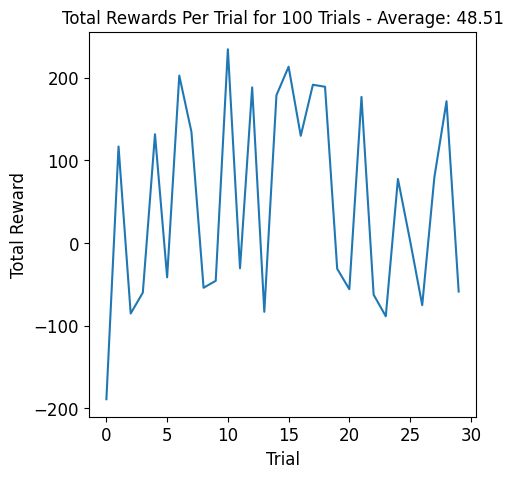

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/HW4/model with batch size_64/output/dqn_agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Total Rewards in this game: -53.65
state space: 8
action space: 4


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


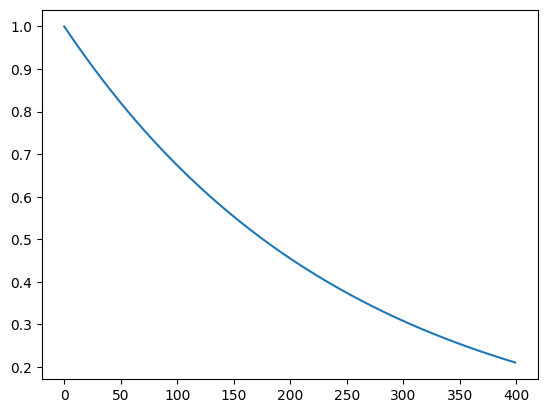

  0%|          | 0/400 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episode 400 Epsilon 0.21 Reward 295.63 Avg_Reward 60.86 Best_Avg_Reward 58.27: 100%|██████████| 400/400 [13:38<00:00,  2.05s/it]


<Figure size 640x480 with 0 Axes>

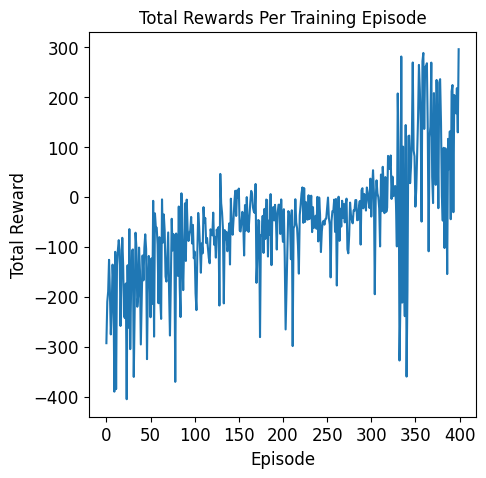

Episode 30.00 Reward 200.02: 100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


<Figure size 640x480 with 0 Axes>

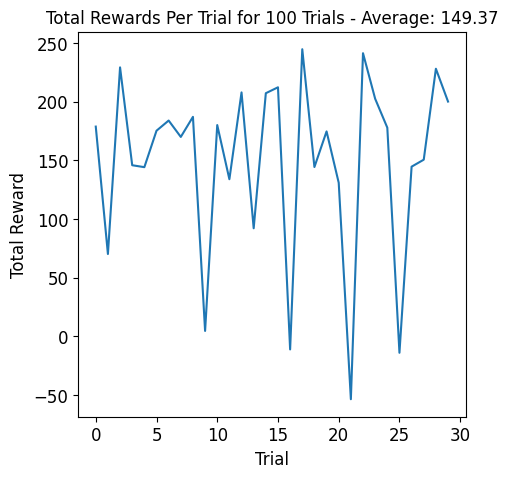

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/HW4/model with batch size_128/output/dqn_agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Total Rewards in this game: 169.20


<Figure size 640x480 with 0 Axes>

In [ ]:
for b in [32,64,128]:
    CURR_PATH = os.path.abspath('/content/drive/MyDrive/HW4/model with batch size_'+str(b)+'/')
    OUTPUT_PATH = os.path.join(CURR_PATH, 'output')
    RANDOM_AGENT_PATH = os.path.join(OUTPUT_PATH, 'random_agent')
    DQN_AGENT_PATH = os.path.join(OUTPUT_PATH, 'dqn_agent')
    DQN_CHECKPOINT_PATH = os.path.join(DQN_AGENT_PATH, 'policy_model_checkpoint.pth')
    DQN_RESULT_IMG_PATH = os.path.join(DQN_AGENT_PATH, 'result_img_{}.png')

    for p in [RANDOM_AGENT_PATH, DQN_AGENT_PATH]:
        if not os.path.exists(p):
            os.makedirs(p)

    env = gym.make('LunarLander-v2')
    n_states, n_actions = env.observation_space.shape[0], env.action_space.n
    print('state space: {}'.format(n_states))
    print('action space: {}'.format(n_actions))

    batch_size = b
    hidden_size = 64
    memory_size = int(1e5)
    update_step = 4
    learning_rate = 5e-4
    gamma = 0.99
    tau = 1e-2

    n_episodes = 400
    max_epsilon = 1.0
    min_epsilon = 0.01
    decay_rate = 0.004
    rewards_window_size = 100


    epsilon_array = np.zeros((n_episodes))
    for i in range(n_episodes):
        epsilon = min_epsilon + (max_epsilon-min_epsilon)*np.exp(-decay_rate*i)
        epsilon_array[i] = epsilon

    plt.plot(epsilon_array)
    plt.show()
    plt.savefig( CURR_PATH +  '/epsilon_array.png')

    agent = DQN_Agent(n_states, n_actions, batch_size, hidden_size, memory_size, update_step, learning_rate, gamma, tau)
    train_rewards, train_rewards_deque = dqn_learn_op(n_episodes, rewards_window_size, epsilon_array)


    plt.subplots(figsize = (5, 5), dpi=100)
    plt.plot(train_rewards)
    plt.ylabel('Total Reward', fontsize=12)
    plt.xlabel('Episode', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Total Rewards Per Training Episode', fontsize=12)
    plt.show()
    plt.savefig( CURR_PATH +  '/Train total Revard.png')

    # EVAL
    test_episodes=30
    test_reward_array = np.zeros(30)
    agent = DQN_Agent(n_states, n_actions, batch_size, hidden_size, memory_size, update_step, learning_rate, gamma, tau)
    agent.policy_model.load_state_dict(torch.load(DQN_CHECKPOINT_PATH, map_location=agent.device))

    t = trange(test_episodes, leave=True)
    for episode in t:
        state = env.reset()
        done = False
        rewards = 0.
        while not done:
            action = agent.act(state, epsilon=0)
            state, reward, done, _ = env.step(action)
            rewards += reward
        t.set_description('Episode {:.2f} Reward {:.2f}'.format(episode + 1, rewards))
        t.refresh()
        test_reward_array[episode] = rewards
    env.close()


    avg_test_reward = round(np.mean(test_reward_array), 2)
    plt.subplots(figsize = (5, 5), dpi=100)
    plt.plot(test_reward_array)
    plt.ylabel('Total Reward', fontsize=12)
    plt.xlabel('Trial', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Total Rewards Per Trial for 100 Trials - Average: {:.2f}'.format(avg_test_reward), fontsize=12)
    plt.show()
    plt.savefig( CURR_PATH +  'Eval total Revard.png')

    env = RecordEpisodeStatistics(env)
    env = RecordVideo(env, video_folder=DQN_AGENT_PATH, episode_trigger=lambda x: x % 1 == 0, name_prefix="random-agent")
    state = env.reset()
    done = False
    rewards = 0.
    while True:
        action = agent.act(state, epsilon=0)
        state, reward, done, _ = env.step(action)
        rewards += reward
        if done:
            print('Total Rewards in this game: {:.2f}'.format(rewards))
            break
    env.close()





# episode 50, 100, 150, 200, 250

In [12]:
class DQN_Graph(nn.Module):
    """
    Deep Q-Learning Network Model Graph
    The neural network is a function from state space $R^{n_states}$ to action space $R^{n_actions}$
    """
    def __init__(self, n_states, n_actions, hidden_size=32):
        super(DQN_Graph, self).__init__()
        self.dense_layer_1 = nn.Linear(n_states, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, n_actions)

    def forward(self, state):
        x = F.relu(self.dense_layer_1(state))
        x = F.relu(self.dense_layer_2(x))
        return self.output_layer(x)

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [None] * capacity
        self.position = 0
        self.Transition = namedtuple('Transition',
                                     ('state', 'action', 'reward', 'next_state', 'done'))

    def size(self):
        return len(self.memory) - self.memory.count(None)

    def push(self, *args):
        self.memory[self.position] = self.Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def pull(self):
        return [exp for exp in self.memory if exp is not None]

    def sample(self, batch_size):
        exps = random.sample(self.pull(), batch_size)
        states = torch.tensor(np.vstack([e.state for e in exps if e is not None])).float().to(self.device)
        actions = torch.tensor(np.vstack([e.action for e in exps if e is not None])).long().to(self.device)
        rewards = torch.tensor(np.vstack([e.reward for e in exps if e is not None])).float().to(self.device)
        next_states = torch.tensor(np.vstack([e.next_state for e in exps if e is not None])).float().to(self.device)
        dones = torch.tensor(np.vstack([e.done for e in exps if e is not None]).astype(np.uint8)).float().to(self.device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)



class DQN_Agent():
    def __init__(self, n_states, n_actions, batch_size, hidden_size, memory_size,
                 update_step, learning_rate, gamma, tau):
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.update_step = update_step
        self.lr = learning_rate
        self.gamma = gamma
        self.tau = tau
        self.setup_gpu()
        self.setup_model()
        self.setup_opt()
        self.memory = ReplayMemory(memory_size)
        self.memory.device = self.device  # Ensure memory uses the correct device
        self.prepare_train()

    def setup_gpu(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def setup_model(self):
        self.policy_model = DQN_Graph(self.n_states, self.n_actions, self.hidden_size).to(self.device)
        self.target_model = DQN_Graph(self.n_states, self.n_actions, self.hidden_size).to(self.device)

    def setup_opt(self):
        self.opt = torch.optim.Adam(self.policy_model.parameters(), lr=self.lr)

    def prepare_train(self):
        self.steps = 0

    def act(self, state, epsilon):
        state = torch.tensor(state).reshape(1, -1).float().to(self.device)
        self.policy_model.eval()
        with torch.no_grad():
            action_vs = self.policy_model(state)
        self.policy_model.train()
        if np.random.random() > epsilon:
            return np.argmax(action_vs.cpu().detach().numpy())
        else:
            return np.random.randint(self.n_actions)

    def step(self, s, a, r, s_, done):
        self.memory.push(s, a, r, s_, done)
        self.steps = (self.steps + 1) % self.update_step
        if self.steps == 0 and self.memory.size() >= self.batch_size:
            exps = self.memory.sample(self.batch_size)
            self.learn(exps)

    def learn(self, exps):
        states, actions, rewards, next_states, dones = exps
        target_next_action_vs = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
        target_q_vs = rewards + (self.gamma * target_next_action_vs * (1 - dones))
        policy_q_vs = self.policy_model(states).gather(1, actions)
        loss = F.mse_loss(policy_q_vs, target_q_vs)
        self.opt.zero_grad()
        loss.backward()
        for p in self.policy_model.parameters():
            p.grad.data.clamp_(-1, 1)
        self.opt.step()
        for tp, lp in zip(self.target_model.parameters(), self.policy_model.parameters()):
            tp.data.copy_(self.tau*lp.data + (1.0-self.tau)*tp.data)



def dqn_learn_op(n_episodes, rewards_window_size, epsilon_array):
    best_avg_rewards = -150.
    total_rewards = []
    rewards_deque = deque(maxlen=rewards_window_size)
    t = trange(n_episodes)
    for episode in t:
        cur_state = env.reset()
        done = False
        rewards = 0
        epsilon = epsilon_array[episode]
        while not done:
            action = agent.act(cur_state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.step(cur_state, action, reward, next_state, done)
            cur_state = next_state
            rewards += reward
        total_rewards.append(rewards)
        rewards_deque.append(rewards)
        avg_rewards = np.mean(rewards_deque)
        t.set_description(
            'Episode {} Epsilon {:.2f} Reward {:.2f} Avg_Reward {:.2f} Best_Avg_Reward {:.2f}'.format(
                episode + 1, epsilon, rewards, avg_rewards, best_avg_rewards))
        t.refresh()
        path = '/content/episods/'
        if not os.path.exists(path):
            os.makedirs(path)
        if episode ==50:
            torch.save(agent.policy_model.state_dict(), path + 'episode_' + str(episode) + '_policy_model_checkpoint.pth')
        if episode ==100:
            torch.save(agent.policy_model.state_dict(), path + 'episode_' + str(episode) + '_policy_model_checkpoint.pth')
        if episode ==150:
            torch.save(agent.policy_model.state_dict(), path + 'episode_' + str(episode) + '_policy_model_checkpoint.pth')
        if episode ==200:
            torch.save(agent.policy_model.state_dict(), path + 'episode_' + str(episode) + '_policy_model_checkpoint.pth')
        if episode ==250:
            torch.save(agent.policy_model.state_dict(), path + 'episode_' + str(episode) + '_policy_model_checkpoint.pth')
        if episode ==300:
            torch.save(agent.policy_model.state_dict(), path + 'episode_' + str(episode) + '_policy_model_checkpoint.pth')
        if episode ==350:
            torch.save(agent.policy_model.state_dict(), path + 'episode_' + str(episode) + '_policy_model_checkpoint.pth')
        if avg_rewards >= best_avg_rewards:
            best_avg_rewards = avg_rewards
            torch.save(agent.policy_model.state_dict(), path + 'best_policy_model_checkpoint.pth')
        if best_avg_rewards > 200:
            break
    return total_rewards, rewards_deque

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


state space: 8
action space: 4


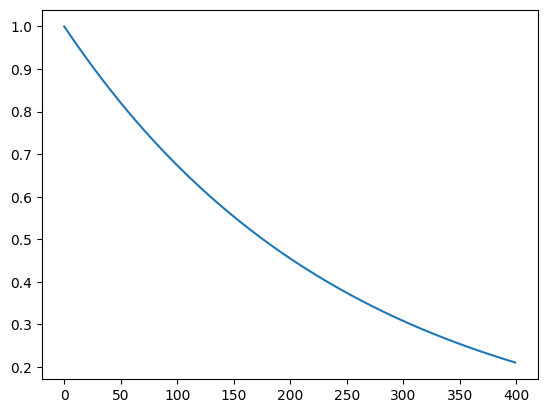

  0%|          | 0/400 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episode 400 Epsilon 0.21 Reward -93.28 Avg_Reward -54.13 Best_Avg_Reward -47.55: 100%|██████████| 400/400 [08:15<00:00,  1.24s/it]


<Figure size 640x480 with 0 Axes>

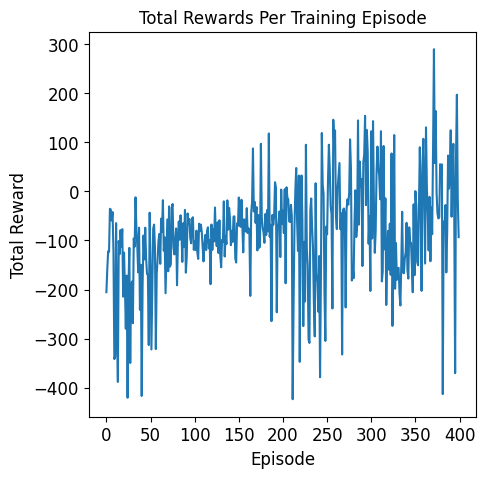

<Figure size 640x480 with 0 Axes>

In [13]:

CURR_PATH = os.path.abspath('')
OUTPUT_PATH = os.path.join(CURR_PATH, 'output')
DQN_AGENT_PATH = os.path.join(OUTPUT_PATH, 'dqn_agent')
DQN_CHECKPOINT_PATH = os.path.join(DQN_AGENT_PATH, 'policy_model_checkpoint.pth')

if not os.path.exists(DQN_AGENT_PATH):
    os.makedirs(DQN_AGENT_PATH)

env = gym.make('LunarLander-v2')
n_states, n_actions = env.observation_space.shape[0], env.action_space.n
print('state space: {}'.format(n_states))
print('action space: {}'.format(n_actions))

batch_size = 128
hidden_size = 64
memory_size = int(1e5)
update_step = 4
learning_rate = 5e-4
gamma = 0.99
tau = 1e-2

n_episodes = 400
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.004
rewards_window_size = 100


epsilon_array = np.zeros((n_episodes))
for i in range(n_episodes):
    epsilon = min_epsilon + (max_epsilon-min_epsilon)*np.exp(-decay_rate*i)
    epsilon_array[i] = epsilon

plt.plot(epsilon_array)
plt.show()
plt.savefig( CURR_PATH +  '/epsilon_array.png')

agent = DQN_Agent(n_states, n_actions, batch_size, hidden_size, memory_size, update_step, learning_rate, gamma, tau)
train_rewards, train_rewards_deque = dqn_learn_op(n_episodes, rewards_window_size, epsilon_array)


plt.subplots(figsize = (5, 5), dpi=100)
plt.plot(train_rewards)
plt.ylabel('Total Reward', fontsize=12)
plt.xlabel('Episode', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Total Rewards Per Training Episode', fontsize=12)
plt.show()
plt.savefig( CURR_PATH +  '/Train total Revard.png')




/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episode 10.00 Reward -382.98: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


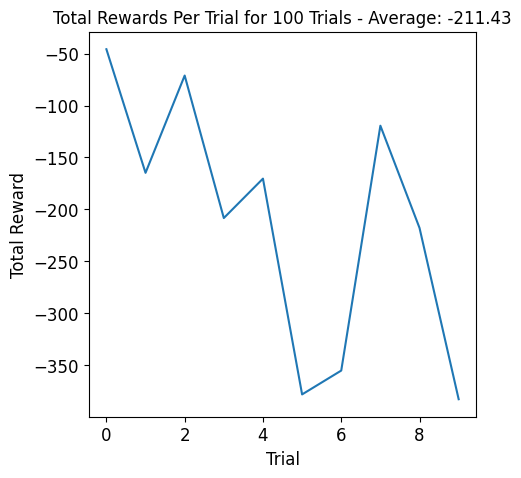

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/output/episode_50_dqn_agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment 

Total Rewards in this game: -191.45


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episode 10.00 Reward -198.14: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


<Figure size 640x480 with 0 Axes>

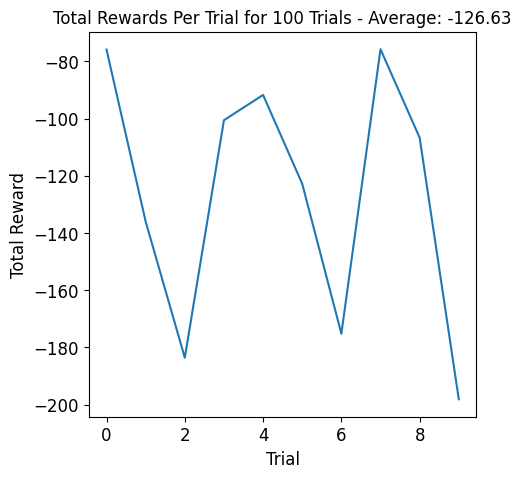

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/output/episode_100_dqn_agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is r

Total Rewards in this game: -103.90


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episode 10.00 Reward -110.75: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


<Figure size 640x480 with 0 Axes>

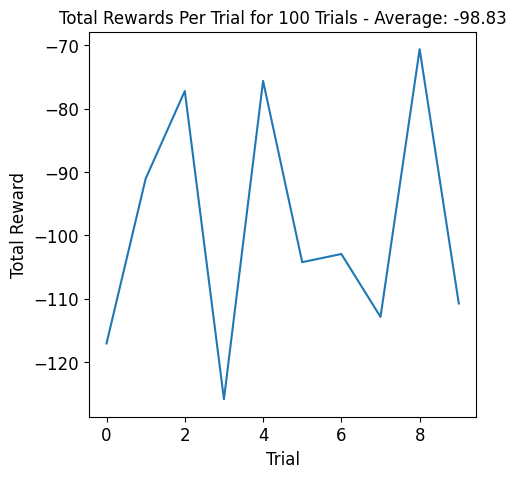

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/output/episode_150_dqn_agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is r

Total Rewards in this game: -122.11


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episode 10.00 Reward -40.78: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


<Figure size 640x480 with 0 Axes>

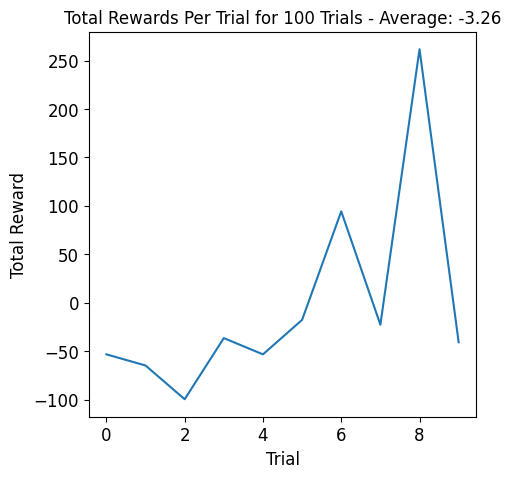

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/output/episode_200_dqn_agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is r

Total Rewards in this game: -71.32


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episode 10.00 Reward -100.88: 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


<Figure size 640x480 with 0 Axes>

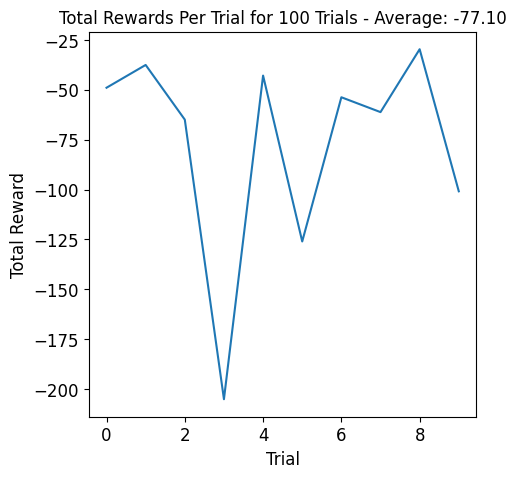

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/output/episode_250_dqn_agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is r

Total Rewards in this game: -54.82


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episode 10.00 Reward -126.38: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


<Figure size 640x480 with 0 Axes>

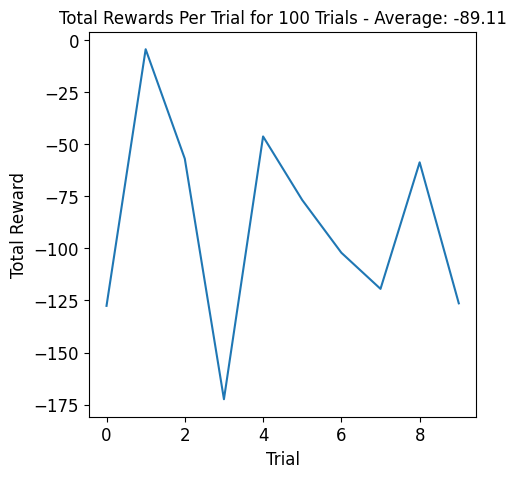

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/output/episode_300_dqn_agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is r

Total Rewards in this game: -45.01


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episode 10.00 Reward -98.86: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


<Figure size 640x480 with 0 Axes>

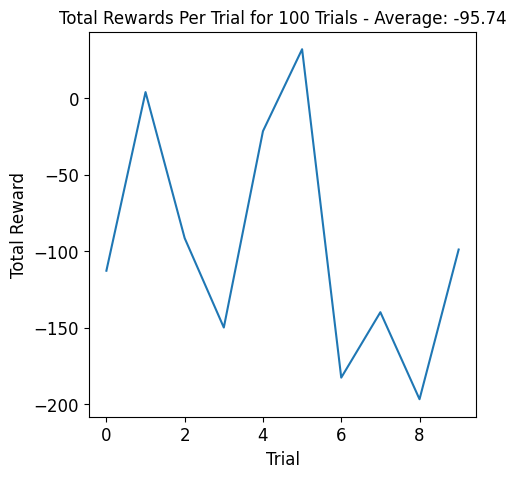

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/output/episode_350_dqn_agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Total Rewards in this game: -115.14


<Figure size 640x480 with 0 Axes>

In [16]:
for e in [50,100,150, 200, 250,300,350]:
    path = '/content/episods/'
    env = gym.make('LunarLander-v2')
    n_states, n_actions = env.observation_space.shape[0], env.action_space.n

    test_episodes=10
    test_reward_array = np.zeros(10)
    agent = DQN_Agent(n_states, n_actions, batch_size, hidden_size, memory_size, update_step, learning_rate, gamma, tau)
    DQN_CHECKPOINT_PATH = path + 'episode_' + str(e) + '_policy_model_checkpoint.pth'
    agent.policy_model.load_state_dict(torch.load(DQN_CHECKPOINT_PATH, map_location=agent.device))

    DQN_AGENT_PATH = os.path.join(OUTPUT_PATH, 'episode_'+str(e)+'_dqn_agent')
    if not os.path.exists(DQN_AGENT_PATH):
        os.makedirs(DQN_AGENT_PATH)

    t = trange(test_episodes, leave=True)
    for episode in t:
        state = env.reset()
        done = False
        rewards = 0.
        while not done:
            action = agent.act(state, epsilon=0)
            state, reward, done, _ = env.step(action)
            rewards += reward
        t.set_description('Episode {:.2f} Reward {:.2f}'.format(episode + 1, rewards))
        t.refresh()
        test_reward_array[episode] = rewards
    env.close()


    avg_test_reward = round(np.mean(test_reward_array), 2)
    plt.subplots(figsize = (5, 5), dpi=100)
    plt.plot(test_reward_array)
    plt.ylabel('Total Reward', fontsize=12)
    plt.xlabel('Trial', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Total Rewards Per Trial for 100 Trials - Average: {:.2f}'.format(avg_test_reward), fontsize=12)
    plt.show()
    plt.savefig( CURR_PATH +'/episode_' +str(e) +'_Eval total Revard.png')

    env = RecordEpisodeStatistics(env)
    env = RecordVideo(env, video_folder=DQN_AGENT_PATH, episode_trigger=lambda x: x % 1 == 0, name_prefix="random-agent")
    state = env.reset()
    done = False
    rewards = 0.
    while True:
        action = agent.act(state, epsilon=0)
        state, reward, done, _ = env.step(action)
        rewards += reward
        if done:
            print('Total Rewards in this game: {:.2f}'.format(rewards))
            break
    env.close()



# DQN vs DDQN

## DQN

In [47]:
class DQN_Graph(nn.Module):
    """
    Deep Q-Learning Network Model Graph
    The neural network is a function from state space $R^{n_states}$ to action space $R^{n_actions}$
    """
    def __init__(self, n_states, n_actions, hidden_size=32):
        super(DQN_Graph, self).__init__()
        self.dense_layer_1 = nn.Linear(n_states, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, n_actions)

    def forward(self, state):
        x = F.relu(self.dense_layer_1(state))
        x = F.relu(self.dense_layer_2(x))
        return self.output_layer(x)

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [None] * capacity
        self.position = 0
        self.Transition = namedtuple('Transition',
                                     ('state', 'action', 'reward', 'next_state', 'done'))

    def size(self):
        return len(self.memory) - self.memory.count(None)

    def push(self, *args):
        self.memory[self.position] = self.Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def pull(self):
        return [exp for exp in self.memory if exp is not None]

    def sample(self, batch_size):
        exps = random.sample(self.pull(), batch_size)
        states = torch.tensor(np.vstack([e.state for e in exps if e is not None])).float().to(self.device)
        actions = torch.tensor(np.vstack([e.action for e in exps if e is not None])).long().to(self.device)
        rewards = torch.tensor(np.vstack([e.reward for e in exps if e is not None])).float().to(self.device)
        next_states = torch.tensor(np.vstack([e.next_state for e in exps if e is not None])).float().to(self.device)
        dones = torch.tensor(np.vstack([e.done for e in exps if e is not None]).astype(np.uint8)).float().to(self.device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)



class DQN_Agent():
    def __init__(self, n_states, n_actions, batch_size, hidden_size, memory_size,
                 update_step, learning_rate, gamma, tau):
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.update_step = update_step
        self.lr = learning_rate
        self.gamma = gamma
        self.tau = tau
        self.setup_gpu()
        self.setup_model()
        self.setup_opt()
        self.memory = ReplayMemory(memory_size)
        self.memory.device = self.device  # Ensure memory uses the correct device
        self.prepare_train()

    def setup_gpu(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def setup_model(self):
        self.policy_model = DQN_Graph(self.n_states, self.n_actions, self.hidden_size).to(self.device)
        self.target_model = DQN_Graph(self.n_states, self.n_actions, self.hidden_size).to(self.device)

    def setup_opt(self):
        self.opt = torch.optim.Adam(self.policy_model.parameters(), lr=self.lr)

    def prepare_train(self):
        self.steps = 0

    def act(self, state, epsilon):
        state = torch.tensor(state).reshape(1, -1).float().to(self.device)
        self.policy_model.eval()
        with torch.no_grad():
            action_vs = self.policy_model(state)
        self.policy_model.train()
        if np.random.random() > epsilon:
            return np.argmax(action_vs.cpu().detach().numpy())
        else:
            return np.random.randint(self.n_actions)

    def step(self, s, a, r, s_, done):
        self.memory.push(s, a, r, s_, done)
        self.steps = (self.steps + 1) % self.update_step
        if self.steps == 0 and self.memory.size() >= self.batch_size:
            exps = self.memory.sample(self.batch_size)
            self.learn(exps)

    def learn(self, exps):
        states, actions, rewards, next_states, dones = exps
        target_next_action_vs = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
        target_q_vs = rewards + (self.gamma * target_next_action_vs * (1 - dones))
        policy_q_vs = self.policy_model(states).gather(1, actions)
        loss = F.mse_loss(policy_q_vs, target_q_vs)
        self.opt.zero_grad()
        loss.backward()
        for p in self.policy_model.parameters():
            p.grad.data.clamp_(-1, 1)
        self.opt.step()
        for tp, lp in zip(self.target_model.parameters(), self.policy_model.parameters()):
            tp.data.copy_(self.tau*lp.data + (1.0-self.tau)*tp.data)



def dqn_learn_op(n_episodes, rewards_window_size, epsilon_array):
    best_avg_rewards = -150.
    total_rewards = []
    rewards_deque = deque(maxlen=rewards_window_size)
    t = trange(n_episodes)
    for episode in t:
        cur_state = env.reset()
        done = False
        rewards = 0
        epsilon = epsilon_array[episode]
        while not done:
            action = agent.act(cur_state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.step(cur_state, action, reward, next_state, done)
            cur_state = next_state
            rewards += reward
        total_rewards.append(rewards)
        rewards_deque.append(rewards)
        avg_rewards = np.mean(rewards_deque)
        t.set_description(
            'Episode {} Epsilon {:.2f} Reward {:.2f} Avg_Reward {:.2f} Best_Avg_Reward {:.2f}'.format(
                episode + 1, epsilon, rewards, avg_rewards, best_avg_rewards))
        t.refresh()
        path = '/content/DQNvsDDQN/DQN/'
        if not os.path.exists(path):
            os.makedirs(path)
        if episode ==100:
            torch.save(agent.policy_model.state_dict(), path + 'episode_' + str(episode) + '_policy_model_checkpoint.pth')
        if episode ==250:
            torch.save(agent.policy_model.state_dict(), path + 'episode_' + str(episode) + '_policy_model_checkpoint.pth')
        if avg_rewards >= best_avg_rewards:
            best_avg_rewards = avg_rewards
            torch.save(agent.policy_model.state_dict(), path + 'best_policy_model_checkpoint.pth')
        if best_avg_rewards > 200:
            break
    return total_rewards, rewards_deque


## DDQN

In [54]:
class DDQN_Graph(nn.Module):
    """
    Deep Reinforcement Learning with Double Q-Learning by Hasselt et al. (2016)
    Double Deep Q-Network Model Graph
    The neural network is a function from state space $R^{n_states}$ to action space $R^{n_actions}$

    """
    def __init__(self, n_states, n_actions, hidden_size=32):
        super(DDQN_Graph, self).__init__()
        self.n_actions = n_actions
        self.half_hidden_size = int(hidden_size/2)
        # hidden representation
        self.dense_layer_1 = nn.Linear(n_states, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        # V(s)
        self.v_layer_1 = nn.Linear(hidden_size, self.half_hidden_size)
        self.v_layer_2 = nn.Linear(self.half_hidden_size, 1)
        # A(s, a)
        self.a_layer_1 = nn.Linear(hidden_size, self.half_hidden_size)
        self.a_layer_2 = nn.Linear(self.half_hidden_size, n_actions)

    def forward(self, state):
        # state: batch_size, state_size
        # x: batch_size, hidden_size
        x = F.relu(self.dense_layer_1(state))
        # x: batch_size, hidden_size
        x = F.relu(self.dense_layer_2(x))
        # v: batch_size, half_hidden_size
        v = F.relu(self.v_layer_1(x))
        # v: batch_size, 1
        v = self.v_layer_2(v)
        # a: batch_size, half_hidden_size
        a = F.relu(self.a_layer_1(x))
        # a: batch_size, action_size
        a = self.a_layer_2(a)

        # Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
        # batch_size, action_size
        return v + a - a.mean(dim=-1, keepdim=True).expand(-1, self.n_actions)
class ReplayMemory():
    """
    Replay memory records previous observations for the agent to learn later
    by sampling from the memory randomly
    """
    def __init__(self, capacity):
        super(ReplayMemory, self).__init__()
        self.capacity = capacity
        # to avoid empty memory list to insert transitions
        self.memory = [None] * capacity
        self.position = 0
        self.Transition = namedtuple('Transition',
                                     ('state', 'action', 'reward', 'next_state', 'done'))

    def size(self):
        return len(self.memory) - self.memory.count(None)

    def push(self, *args):
        # save a transition at a certain position of the memory
        self.memory[self.position] = self.Transition(*args)
        # update position
        self.position = (self.position + 1) % self.capacity

    def pull(self):
        return [exp for exp in self.memory if exp is not None]

    def sample(self, batch_size):
        exps = random.sample(self.pull(), batch_size)
        states = torch.tensor(np.vstack([e.state for e in exps if e is not None])).float()
        actions = torch.tensor(np.vstack([e.action for e in exps if e is not None])).long()
        rewards = torch.tensor(np.vstack([e.reward for e in exps if e is not None])).float()
        next_states = torch.tensor(np.vstack([e.next_state for e in exps if e is not None])).float()
        dones = torch.tensor(np.vstack([e.done for e in exps if e is not None]).astype(np.uint8)).float()

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

class DDQN_Agent():
    """docstring for ddqn_agent"""
    def __init__(self, n_states, n_actions, batch_size, hidden_size, memory_size,
                 update_step, learning_rate, gamma, tau):
        super(DDQN_Agent, self).__init__()
        # state space dimension
        self.n_states = n_states
        # action space dimension
        self.n_actions = n_actions
        # configuration
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.update_step = update_step
        self.lr = learning_rate
        self.gamma = gamma
        self.tau = tau
        # check cpu or gpu
        self.setup_gpu()
        # initialize model graph
        self.setup_model()
        # initialize optimizer
        self.setup_opt()
        # enable Replay Memory
        self.memory = ReplayMemory(memory_size)
        # others
        self.prepare_train()

    def setup_gpu(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def setup_model(self):
        self.policy_model = DDQN_Graph(
            self.n_states,
            self.n_actions,
            self.hidden_size).to(self.device)
        self.target_model = DDQN_Graph(
            self.n_states,
            self.n_actions,
            self.hidden_size).to(self.device)

    def setup_opt(self):
        self.opt = torch.optim.Adam(self.policy_model.parameters(), lr=self.lr)

    def prepare_train(self):
        self.steps = 0

    def act(self, state, epsilon):
      state = torch.tensor(state).reshape(1, -1).to(self.device)
      self.policy_model.eval()
      with torch.no_grad():
          action_vs = self.policy_model(state)
      self.policy_model.train()
      if np.random.random() > epsilon:
          return np.argmax(action_vs.cpu().detach().numpy())
      else:
          return np.random.randint(self.n_actions)


    def step(self, s, a, r, s_, done):
        # add one observation to memory
        self.memory.push(s, a, r, s_, done)
        # update model for every certain steps
        self.steps = (self.steps + 1) % self.update_step
        if self.steps == 0 and self.memory.size() >= self.batch_size:
            exps = self.memory.sample(self.batch_size)
            self.learn(exps)
        else:
            pass

    def learn(self, exps, soft_copy=True):
      states, actions, rewards, next_states, dones = exps
      states = states.to(self.device)
      actions = actions.to(self.device)
      rewards = rewards.to(self.device)
      next_states = next_states.to(self.device)
      dones = dones.to(self.device)

      # target side
      _, next_idx = self.policy_model(next_states).detach().max(1)
      target_next_action_vs = self.target_model(next_states).detach().gather(1, next_idx.unsqueeze(1))
      target_q_vs = rewards + (self.gamma * target_next_action_vs * (1 - dones))

      # policy side
      policy_q_vs = self.policy_model(states).gather(1, actions)
      loss = F.mse_loss(policy_q_vs, target_q_vs)

      self.opt.zero_grad()
      loss.backward()
      for p in self.policy_model.parameters():
          p.grad.data.clamp_(-1, 1)
      self.opt.step()

      if soft_copy:
          for tp, lp in zip(self.target_model.parameters(), self.policy_model.parameters()):
              tp.data.copy_(self.tau * lp.data + (1.0 - self.tau) * tp.data)
      else:
          self.target_model.load_state_dict(self.policy_model.state_dict())



def ddqn_learn_op(n_episodes, rewards_window_size, epsilon_array):
    best_avg_rewards = -100.
    total_rewards = []
    rewards_deque = deque(maxlen=rewards_window_size)
    t = trange(n_episodes)
    for episode in t:
        # initialize the state
        cur_state = env.reset()
        done = False
        rewards = 0
        epsilon = epsilon_array[episode]
        while not done:
            action = agent.act(cur_state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.step(cur_state, action, reward, next_state, done)
            cur_state = next_state
            rewards += reward
        # update information
        total_rewards.append(rewards)
        rewards_deque.append(rewards)
        avg_rewards = np.mean(rewards_deque)
        t.set_description(
            'Episode {} Epsilon {:.2f} Reward {:.2f} Avg_Reward {:.2f} Best_Avg_Reward {:.2f}'.format(
                episode + 1, epsilon, rewards, avg_rewards, best_avg_rewards))
        t.refresh()
        # evaluation
        path = '/content/DQNvsDDQN/DDQN/'
        if not os.path.exists(path):
            os.makedirs(path)
        if episode ==100:
            torch.save(agent.policy_model.state_dict(), path + 'episode_' + str(episode) + '_policy_model_checkpoint.pth')
        if episode ==250:
            torch.save(agent.policy_model.state_dict(), path + 'episode_' + str(episode) + '_policy_model_checkpoint.pth')
        if avg_rewards >= best_avg_rewards:
            best_avg_rewards = avg_rewards
            torch.save(agent.policy_model.state_dict(), path + 'best_policy_model_checkpoint.pth')

        # the game is solved by earning more than +200 rewards for a single episode
        if best_avg_rewards > 200:
            break
    return total_rewards, rewards_deque

## Run

In [48]:
CURR_PATH = os.path.abspath('DQNvsDDQN')
OUTPUT_PATH = os.path.join(CURR_PATH, 'output')
DQN_AGENT_PATH = os.path.join(OUTPUT_PATH, 'dqn_agent')
DQN_CHECKPOINT_PATH = os.path.join(DQN_AGENT_PATH, 'policy_model_checkpoint.pth')

if not os.path.exists(DQN_AGENT_PATH):
    os.makedirs(DQN_AGENT_PATH)

DDQN_AGENT_PATH = os.path.join(OUTPUT_PATH, 'ddqn_agent')
DDQN_CHECKPOINT_PATH = os.path.join(DDQN_AGENT_PATH, 'policy_model_checkpoint.pth')

if not os.path.exists(DDQN_AGENT_PATH):
    os.makedirs(DDQN_AGENT_PATH)

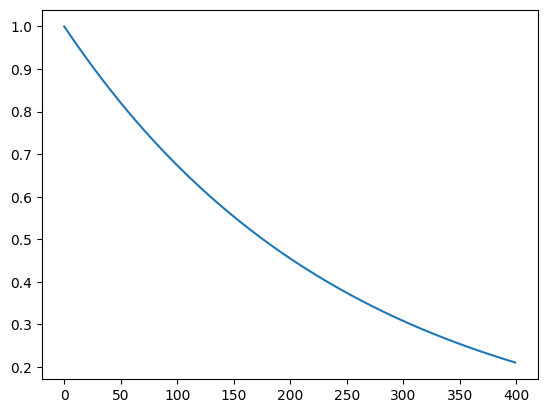

In [49]:
batch_size = 128
hidden_size = 64
memory_size = int(1e5)
update_step = 4
learning_rate = 5e-4
gamma = 0.99
tau = 1e-2

n_episodes = 400
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.004
rewards_window_size = 100

epsilon_array = np.zeros((n_episodes))
for i in range(n_episodes):
    epsilon = min_epsilon + (max_epsilon-min_epsilon)*np.exp(-decay_rate*i)
    epsilon_array[i] = epsilon

plt.plot(epsilon_array)
plt.show()

Episode 400 Epsilon 0.21 Reward 13.30 Avg_Reward 15.63 Best_Avg_Reward 15.98: 100%|██████████| 400/400 [13:25<00:00,  2.01s/it]


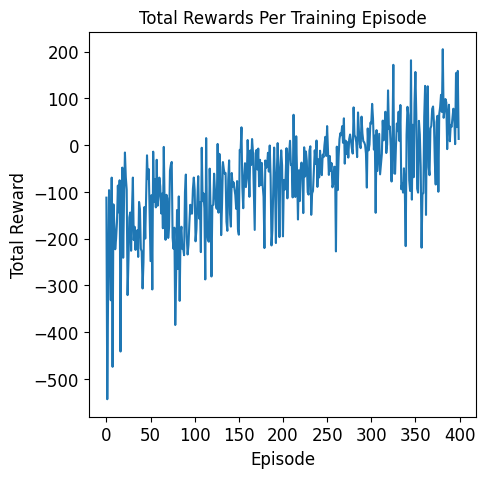

In [50]:
env = gym.make('LunarLander-v2')
n_states, n_actions = env.observation_space.shape[0], env.action_space.n

agent = DQN_Agent(n_states, n_actions, batch_size, hidden_size, memory_size, update_step, learning_rate, gamma, tau)
train_rewards, train_rewards_deque = dqn_learn_op(n_episodes, rewards_window_size, epsilon_array)
plt.subplots(figsize = (5, 5), dpi=100)
plt.plot(train_rewards)
plt.ylabel('Total Reward', fontsize=12)
plt.xlabel('Episode', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Total Rewards Per Training Episode', fontsize=12)
plt.show()

# DDQN

Episode 400 Epsilon 0.21 Reward 28.58 Avg_Reward 78.26 Best_Avg_Reward 77.64: 100%|██████████| 400/400 [12:39<00:00,  1.90s/it]


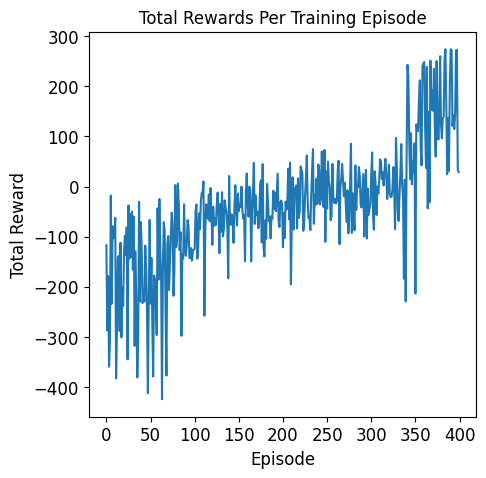

In [55]:
env = gym.make('LunarLander-v2')
n_states, n_actions = env.observation_space.shape[0], env.action_space.n
agent = DDQN_Agent(n_states,
                   n_actions,
                   batch_size,
                   hidden_size,
                   memory_size,
                   update_step,
                   learning_rate,
                   gamma,
                   tau)

train_rewards, train_rewards_deque = ddqn_learn_op(n_episodes, rewards_window_size, epsilon_array)

plt.subplots(figsize = (5, 5), dpi=100)
plt.plot(train_rewards)
plt.ylabel('Total Reward', fontsize=12)
plt.xlabel('Episode', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Total Rewards Per Training Episode', fontsize=12)
plt.show()


## EVAL

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episode 30.00 Reward -149.26: 100%|██████████| 30/30 [00:44<00:00,  1.48s/it]


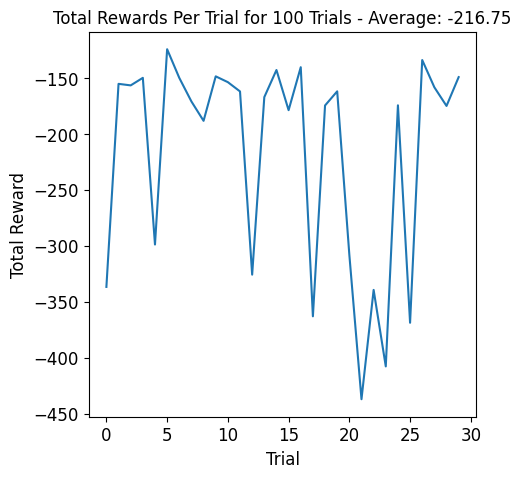

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/DQNvsDDQN/DQN/videoDQNepisode_episode_100 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of

Total Rewards in this game: -502.09


  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episode 30.00 Reward -14.05: 100%|██████████| 30/30 [00:51<00:00,  1.73s/it]


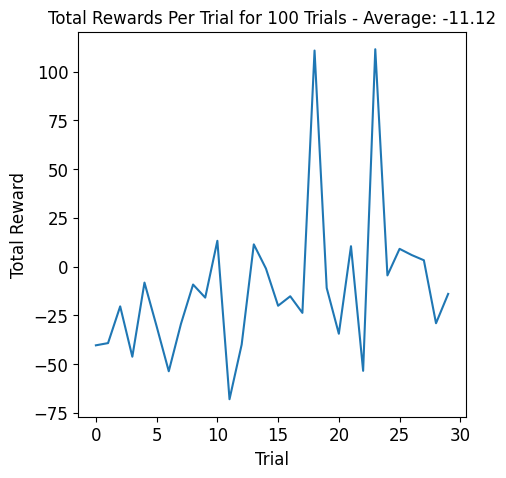

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which retu

Total Rewards in this game: -22.74


  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episode 30.00 Reward 171.86: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


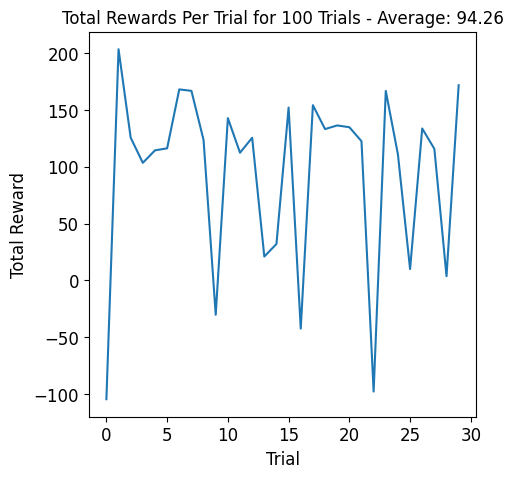

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which retu

Total Rewards in this game: 158.70


  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episode 30.00 Reward -95.71: 100%|██████████| 30/30 [00:57<00:00,  1.90s/it]


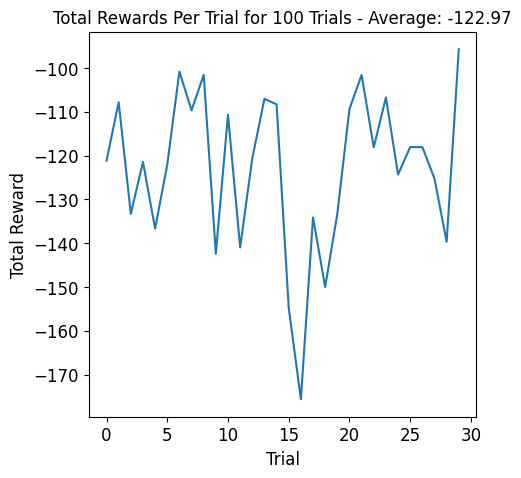

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which retu

Total Rewards in this game: -114.18


  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episode 30.00 Reward -74.91: 100%|██████████| 30/30 [00:55<00:00,  1.85s/it]


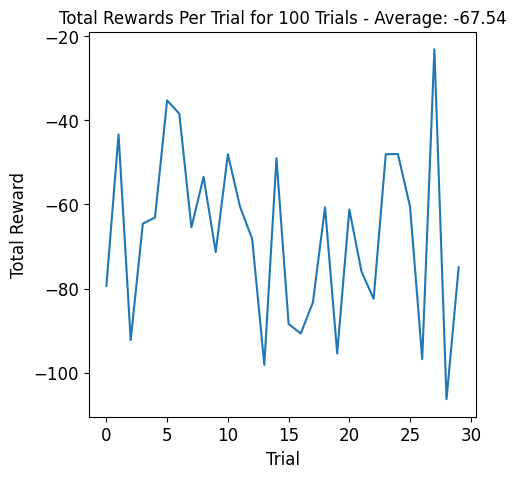

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which retu

Total Rewards in this game: -84.67


  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Episode 30.00 Reward 250.22: 100%|██████████| 30/30 [00:09<00:00,  3.07it/s]


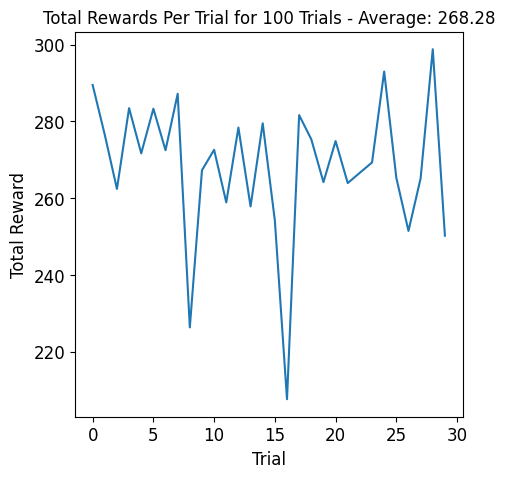

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Total Rewards in this game: 260.12


In [58]:
for mdl in  ['DQN', 'DDQN']:
    path = '/content/DQNvsDDQN/'+str(mdl)+'/'
    for e in ['episode_100', 'episode_250', 'best']:
        env = gym.make('LunarLander-v2')
        n_states, n_actions = env.observation_space.shape[0], env.action_space.n

        test_episodes=30
        test_reward_array = np.zeros(30)
        if mdl == 'DQN':
            agent = DQN_Agent(n_states, n_actions, batch_size, hidden_size, memory_size, update_step, learning_rate, gamma, tau)
        if mdl =='DDQN':
            agent = DDQN_Agent(n_states,
                   n_actions,
                   batch_size,
                   hidden_size,
                   memory_size,
                   update_step,
                   learning_rate,
                   gamma,
                   tau)
        DQN_CHECKPOINT_PATH = path + e + '_policy_model_checkpoint.pth'
        agent.policy_model.load_state_dict(torch.load(DQN_CHECKPOINT_PATH, map_location=agent.device))

        t = trange(test_episodes, leave=True)
        for episode in t:
            state = env.reset()
            done = False
            rewards = 0.
            while not done:
                action = agent.act(state, epsilon=0)
                state, reward, done, _ = env.step(action)
                rewards += reward
            t.set_description('Episode {:.2f} Reward {:.2f}'.format(episode + 1, rewards))
            t.refresh()
            test_reward_array[episode] = rewards
        env.close()
        avg_test_reward = round(np.mean(test_reward_array), 2)
        plt.subplots(figsize = (5, 5), dpi=100)
        plt.plot(test_reward_array)
        plt.ylabel('Total Reward', fontsize=12)
        plt.xlabel('Trial', fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title('Total Rewards Per Trial for 100 Trials - Average: {:.2f}'.format(avg_test_reward), fontsize=12)
        plt.show()

        env = RecordEpisodeStatistics(env)

        DQN_AGENT_PATH = path +'video'+str(mdl)+'episode_'+str(e)
        env = RecordVideo(env, video_folder=DQN_AGENT_PATH, episode_trigger=lambda x: x % 1 == 0, name_prefix="random-agent")

        state = env.reset()
        done = False
        rewards = 0.
        while True:
            action = agent.act(state, epsilon=0)
            state, reward, done, _ = env.step(action)
            rewards += reward
            if done:
                print('Total Rewards in this game: {:.2f}'.format(rewards))
                break
        env.close()


In [59]:
!zip -r /content/DQNvsDDQN.zip /content/DQNvsDDQN

from google.colab import files
files.download("/content/DQNvsDDQN.zip")

  adding: content/DQNvsDDQN/ (stored 0%)
  adding: content/DQNvsDDQN/DDQN/ (stored 0%)
  adding: content/DQNvsDDQN/DDQN/videoDDQNepisode_episode_250/ (stored 0%)
  adding: content/DQNvsDDQN/DDQN/videoDDQNepisode_episode_250/random-agent-episode-0.mp4 (deflated 10%)
  adding: content/DQNvsDDQN/DDQN/videoDDQNepisode_episode_250/random-agent-episode-0.meta.json (deflated 61%)
  adding: content/DQNvsDDQN/DDQN/episode_250_policy_model_checkpoint.pth (deflated 14%)
  adding: content/DQNvsDDQN/DDQN/best_policy_model_checkpoint.pth (deflated 14%)
  adding: content/DQNvsDDQN/DDQN/videoDDQNepisode_episode_100/ (stored 0%)
  adding: content/DQNvsDDQN/DDQN/videoDDQNepisode_episode_100/random-agent-episode-0.mp4 (deflated 10%)
  adding: content/DQNvsDDQN/DDQN/videoDDQNepisode_episode_100/random-agent-episode-0.meta.json (deflated 61%)
  adding: content/DQNvsDDQN/DDQN/videoDDQNepisode_best/ (stored 0%)
  adding: content/DQNvsDDQN/DDQN/videoDDQNepisode_best/random-agent-episode-0.mp4 (deflated 14%)
 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
!zip -r /content/output.zip /content/output
from google.colab import files
files.download("/content/output.zip")

  adding: content/output/ (stored 0%)
  adding: content/output/episode_100_dqn_agent/ (stored 0%)
  adding: content/output/episode_100_dqn_agent/random-agent-episode-0.mp4 (deflated 10%)
  adding: content/output/episode_100_dqn_agent/random-agent-episode-0.meta.json (deflated 61%)
  adding: content/output/episode_50_dqn_agent/ (stored 0%)
  adding: content/output/episode_50_dqn_agent/random-agent-episode-0.mp4 (deflated 7%)
  adding: content/output/episode_50_dqn_agent/random-agent-episode-0.meta.json (deflated 61%)
  adding: content/output/episode_250_dqn_agent/ (stored 0%)
  adding: content/output/episode_250_dqn_agent/random-agent-episode-0.mp4 (deflated 9%)
  adding: content/output/episode_250_dqn_agent/random-agent-episode-0.meta.json (deflated 61%)
  adding: content/output/episode_200_dqn_agent/ (stored 0%)
  adding: content/output/episode_200_dqn_agent/random-agent-episode-0.mp4 (deflated 12%)
  adding: content/output/episode_200_dqn_agent/random-agent-episode-0.meta.json (defla

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
!zip -r /content/episods.zip /content/episods
from google.colab import files
files.download("/content/episods.zip")

  adding: content/episods/ (stored 0%)
  adding: content/episods/episode_250_policy_model_checkpoint.pth (deflated 14%)
  adding: content/episods/episode_350_policy_model_checkpoint.pth (deflated 14%)
  adding: content/episods/.ipynb_checkpoints/ (stored 0%)
  adding: content/episods/episode_200_policy_model_checkpoint.pth (deflated 14%)
  adding: content/episods/episode_300_policy_model_checkpoint.pth (deflated 14%)
  adding: content/episods/episode_50_policy_model_checkpoint.pth (deflated 15%)
  adding: content/episods/episode_150_policy_model_checkpoint.pth (deflated 14%)
  adding: content/episods/episode_100_policy_model_checkpoint.pth (deflated 15%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>